In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
os.chdir(r"/content/gdrive/My Drive/Arineo/Segmentierung")

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import json
import base64
from numpy.random import randint, uniform
from matplotlib import pyplot as plt
from skimage import io
from skimage.transform import resize, rotate, ProjectiveTransform, warp
from PIL import Image
from io import BytesIO
from skimage.util import img_as_float32, img_as_ubyte
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model

In [ ]:
def create_Unet_model(pretrained_weights = None, 
                      input_size = (256,256,3)):
    input_img = Input(shape=input_size, name="img")
    input_clickpoint = Input(shape=(input_size[0], input_size[1], 1), name="clickpoint")
    inputs = Concatenate()([input_img, input_clickpoint])
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    output_contour = Conv2D(1, 1, activation = 'sigmoid', name='contour')(conv9)

    model = Model([input_img, input_clickpoint], [output_contour])

    model.compile(optimizer = Adam(learning_rate = 1e-3), 
                  loss = {'contour': 'binary_crossentropy'}, 
                  metrics = ['accuracy'])
    if(pretrained_weights):
      print('Load pretrained weights')
      model.load_weights(pretrained_weights)

    return model

In [ ]:
tf.keras.backend.clear_session()
model = create_Unet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
clickpoint (InputLayer)         [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 4)  0           img[0][0]                        
                                                                 clickpoint[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 592         concatenate[0][0]            

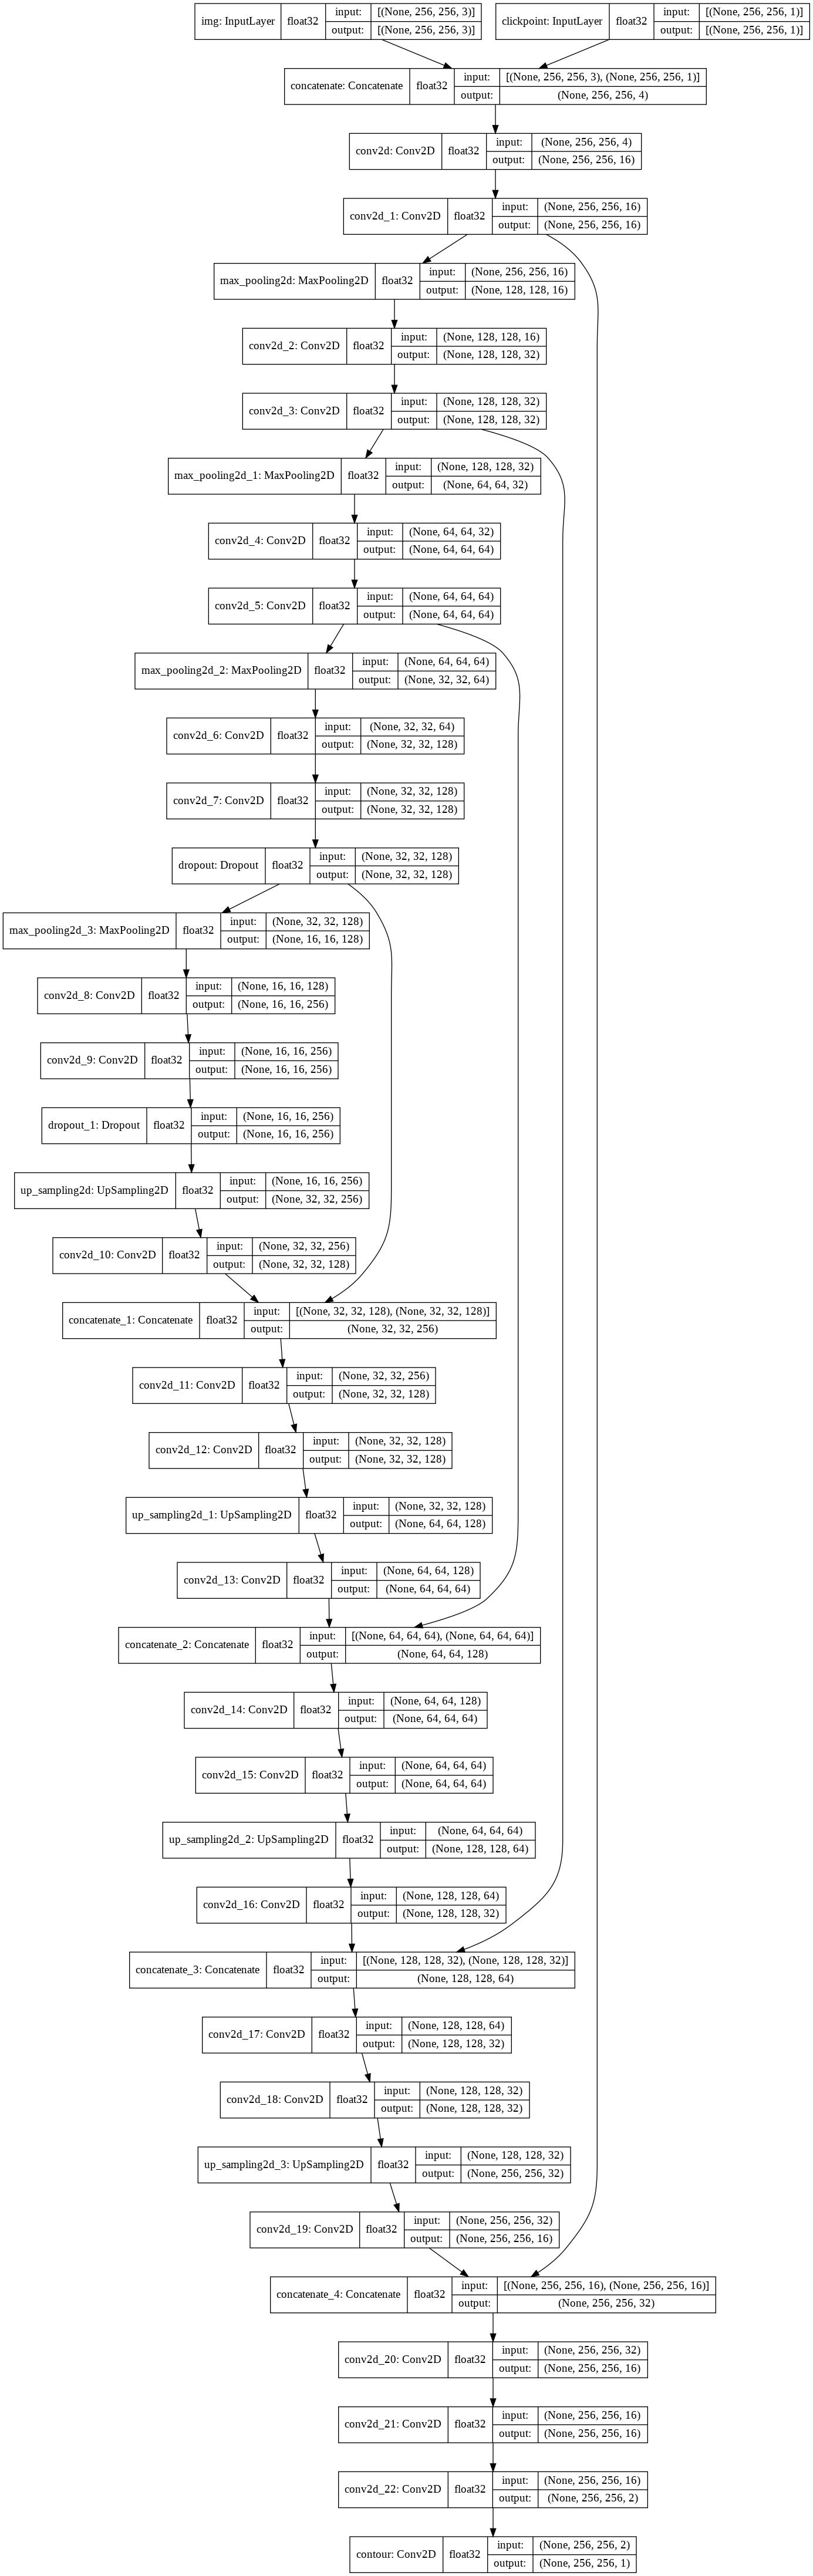

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [ ]:
def load_image_polygon_from_json(filename):
    with open(filename) as json_file:
        data = json.load(json_file)
    image = data['image']
    imbytes = BytesIO(base64.b64decode(image))
    image = Image.open(imbytes)
    image = image.convert("RGB")
    image = np.array(image)
    image = img_as_float32(image)
    polygon = data['polygon']
    return image, polygon

def augment_images_and_masks(inputs, 
                             shear=True, 
                             flip=True, 
                             rot=True, 
                             zoom=True, 
                             zoom_pxs=220):
    ims = inputs.copy()
    rand_flip_lr = randint(2)
    rand_flip_ud = randint(2)
    rand_rot = randint(90)
    rand_shear_v = uniform(0, 0.5)
    rand_shear_h = uniform(0, 0.5)
    rand_shear_lr = randint(2)
    rand_shear_ud = randint(2)
    rand_zoom_x_start = randint(1,zoom_pxs)
    rand_zoom_y_start = randint(1,zoom_pxs)
    rand_zoom_x_end = randint(1,zoom_pxs)
    rand_zoom_y_end = randint(1,zoom_pxs)
    for i in range(0, len(inputs)):
      matrix_shear_h = np.array([[1, rand_shear_h, 0], 
                        [0, 1+rand_shear_h, 0], 
                        [0, 0, 1+rand_shear_h]])
      tform_shear_h = ProjectiveTransform(matrix=matrix_shear_h)
      if shear:
        if rand_shear_lr > 0:
          ims[i] = np.fliplr(ims[i])
        ims[i] = warp(ims[i], tform_shear_h.inverse)
        if rand_shear_lr > 0:
          ims[i] = np.fliplr(ims[i])
      
      matrix_shear_v = np.array([[1+rand_shear_v, 0, 0], 
                        [rand_shear_v, 1, 0], 
                        [0, 0, 1+rand_shear_v]])
      tform_shear_v = ProjectiveTransform(matrix=matrix_shear_v)
      if shear:
        if rand_shear_ud > 0:
          ims[i] = np.fliplr(ims[i])
        ims[i] = warp(ims[i], tform_shear_v.inverse)
        if rand_shear_ud > 0:
          ims[i] = np.fliplr(ims[i])
      if flip:
        if rand_flip_lr > 0:
          ims[i] = np.fliplr(ims[i])
        if rand_flip_ud > 0:
          ims[i] = np.flipud(ims[i])
      if rot:
        ims[i] = rotate(ims[i], rand_rot, resize=True)
      if zoom:
        zoom_im = np.copy(ims[i])
        zoom_im = zoom_im[rand_zoom_y_start:-rand_zoom_y_end,rand_zoom_x_end:-rand_zoom_x_end]
        ims[i] = resize(zoom_im, (ims[i].shape[0], ims[i].shape[1]))
    return ims

def train_test_generator(json_filenames, 
                         batch_size, 
                         img_size=(256,256), 
                         shear=True, 
                         flip=True, 
                         rot=True, 
                         zoom=True, 
                         zoom_pxs=220, 
                         shuffle=True, 
                         give_boundary_mask=False):
    indices_filenames = np.arange(0, json_filenames.shape[0])
    i = 0
    while True:
      if i == 0:
        if shuffle:
          np.random.shuffle(indices_filenames)
      batch_indices = indices_filenames[i:i+batch_size]
      batch_filenames = json_filenames[batch_indices]

      for j in range(0, batch_size):
        filename = batch_filenames[j]
        img, polygon = load_image_polygon_from_json(filename)
        points = np.array(polygon[0])
        mask_contour_small = np.zeros(img.shape[0:2], dtype="float32")
        cv2.fillPoly(mask_contour_small,[points], color=(1), 
                     lineType = cv2.LINE_AA)
        mask_contour = np.copy(mask_contour_small)
        cv2.polylines(mask_contour_small,[points],True,(0), thickness = 15, 
                      lineType = cv2.LINE_AA)
        mask_boundary = np.zeros(img.shape[0:2], dtype="float32")
        cv2.polylines(mask_boundary,[points],True,(1), thickness = 3, 
                      lineType = cv2.LINE_AA)
        
        #augment images and masks
        augmented_inputs = augment_images_and_masks([img, 
                                                     mask_contour, 
                                                     mask_boundary, 
                                                     mask_contour_small], 
                                                    shear=shear, 
                                                    flip=flip, 
                                                    rot=rot, 
                                                    zoom=zoom, 
                                                    zoom_pxs=zoom_pxs)
        img = augmented_inputs[0]
        mask_contour = augmented_inputs[1]
        mask_boundary = augmented_inputs[2]
        mask_contour_small = augmented_inputs[3]
        points_in_contour = np.where(mask_contour_small > 0.5)
        rand_index = np.random.randint(0, points_in_contour[0].shape[0])
        point_in_contour = (points_in_contour[1][rand_index], 
                            points_in_contour[0][rand_index])
        mask_clickpoint = np.zeros(img.shape[0:2], dtype="float32")
        cv2.circle(mask_clickpoint, point_in_contour, 9, (1), 
                   thickness=-1, lineType = cv2.LINE_AA)
        
        img = resize(img, img_size)
        mask_contour = resize(mask_contour, img_size)
        mask_boundary = resize(mask_boundary, img_size)
        mask_clickpoint = resize(mask_clickpoint, img_size)
        img = np.expand_dims(img, axis=0)
        mask_contour = np.expand_dims(mask_contour, axis=-1)
        mask_contour = np.expand_dims(mask_contour, axis=0)
        mask_boundary = np.expand_dims(mask_boundary, axis=-1)
        mask_boundary = np.expand_dims(mask_boundary, axis=0)
        mask_clickpoint = np.expand_dims(mask_clickpoint, axis=-1)
        mask_clickpoint = np.expand_dims(mask_clickpoint, axis=0)
        if j == 0:
          batch_imgs = np.copy(img)
          batch_mask_contour = np.copy(mask_contour)
          batch_mask_boundary = np.copy(mask_boundary)
          batch_mask_clickpoint = np.copy(mask_clickpoint)
        else:
          batch_imgs = np.append(batch_imgs, img, axis=0)
          batch_mask_contour = np.append(batch_mask_contour, 
                                         mask_contour, axis=0)
          batch_mask_boundary = np.append(batch_mask_boundary, 
                                          mask_boundary, axis=0)
          batch_mask_clickpoint = np.append(batch_mask_clickpoint, 
                                            mask_clickpoint, axis=0)
      if give_boundary_mask:
        yield [batch_imgs, batch_mask_clickpoint], batch_mask_contour, \
        batch_mask_boundary
      else:
        yield [batch_imgs, batch_mask_clickpoint], batch_mask_contour
      i = i + batch_size
      if (i + batch_size) > indices_filenames.shape[0]:
        i = 0

def save_pred_examples(model, 
                       batch_imgs_test_plot, 
                       batch_mask_clickpoint_test_plot, 
                       batch_mask_contour_test_plot, 
                       batch_mask_boundary_test_plot, 
                       dir="pred_", 
                       log_dir="logs"):
    if not os.path.exists(log_dir):
      os.makedirs(log_dir)
    dir = log_dir+'/'+dir
    n_examples = batch_imgs_test_plot.shape[0]
    preds = model.predict_on_batch([batch_imgs_test_plot, batch_mask_clickpoint_test_plot])
    for n in range(0, n_examples):
      img = np.copy(batch_imgs_test_plot[n,:,:,:])
      mask_clickpoint = np.copy(batch_mask_clickpoint_test_plot[n,:,:,0])
      mask_contour = np.copy(batch_mask_contour_test_plot[n,:,:,0])
      mask_boundary = np.copy(batch_mask_boundary_test_plot[n,:,:,0])
      pred_contour = np.copy(preds[n,:,:,0])
      indices_clickpoint = np.where(mask_clickpoint >= 0.5)
      indices_contour = np.where(mask_contour >= 0.5)
      indices_boundary = np.where(mask_boundary >= 0.5)
      indices_pred_contour = np.where(pred_contour >= 0.5)
      for k in range(0,3):
        img[:,:,k][indices_boundary] = 1
        img[:,:,k][indices_clickpoint] = 1
      img[:,:,0][indices_pred_contour] = 1
      img = img_as_ubyte(img)
      filename = dir+str(n)+".jpg"
      io.imsave(filename, img)

def train_model(model, 
                json_filenames_train, 
                json_filenames_test, 
                epochs=200, 
                batch_size=32, 
                log_dir="logs",  
                savepath="best_weights.hdf5", 
                savepath_hist="history.json", 
                loadpath_hist=None, 
                shear=True, 
                flip=True, 
                rot=True, 
                zoom=True, 
                zoom_pxs=200):
    if not os.path.exists(log_dir):
      os.makedirs(log_dir)
    savepath = log_dir+'/'+savepath
    savepath_hist = log_dir+'/'+savepath_hist
    num_train_samples = json_filenames_train.shape[0]
    num_test_samples = json_filenames_test.shape[0]
    print("Num train-samples: "+str(num_train_samples)+",    Num test-samples: "+str(num_test_samples))
    train_steps = np.floor(num_train_samples/batch_size).astype(int)
    test_steps = num_test_samples
    if loadpath_hist:
      history = json.load(open(loadpath_hist))
    else:
      history = {"loss": [],
                "accuracy": [],
                "val_loss": [],
                "val_accuracy": [],
                }
    
    # The epoch with best weights.
    best_epoch = 0
    best_weights = None
    # Initialize the best validation loss as infinity.
    best_val_loss = np.Inf
    best_val_accuracy = 0
    best_accuracy = 0
    best_loss = np.Inf
    
    train_gen = train_test_generator(json_filenames_train, 
                                     batch_size=batch_size, 
                                     shear=shear, 
                                     flip=flip, 
                                     rot=rot, 
                                     zoom=zoom, 
                                     zoom_pxs=zoom_pxs, 
                                     shuffle=True)
    test_gen = train_test_generator(json_filenames_test, 
                                    1, 
                                    shear=False, 
                                    flip=False, 
                                    rot=False, 
                                    zoom=False, 
                                    shuffle=False)

    #save predicted examples
    batch_size_plot = 20
    test_gen_plot = train_test_generator(json_filenames_test, 
                                         batch_size=batch_size_plot, 
                                         shear=False, 
                                         flip=False, 
                                         rot=False, 
                                         zoom=False, 
                                         shuffle=False, 
                                         give_boundary_mask=True)
    [batch_imgs_test_plot, batch_mask_clickpoint_test_plot], \
    batch_mask_contour_test_plot, batch_mask_boundary_test_plot = \
    next(test_gen_plot)
    save_pred_examples(model, batch_imgs_test_plot, 
                       batch_mask_clickpoint_test_plot, 
                       batch_mask_contour_test_plot, 
                       batch_mask_boundary_test_plot)
    train_gen_plot = train_test_generator(json_filenames_train, 
                                          batch_size=batch_size_plot, 
                                          shear=False, 
                                          flip=False, 
                                          rot=False, 
                                          zoom=False, 
                                          shuffle=False, 
                                          give_boundary_mask=True)
    [batch_imgs_train_plot, batch_mask_clickpoint_train_plot], \
    batch_mask_contour_train_plot, batch_mask_boundary_train_plot = \
    next(train_gen_plot)
    save_pred_examples(model, 
                       batch_imgs_train_plot, 
                       batch_mask_clickpoint_train_plot, 
                       batch_mask_contour_train_plot, 
                       batch_mask_boundary_train_plot, 
                       dir='train_')

    for epoch in range(0, epochs):
      loss = []
      val_loss = []
      accuracy = []
      val_accuracy = []
      for step in range(0, train_steps):
        X_train_batch, y_train_batch = next(train_gen)
        metrics = model.train_on_batch(X_train_batch, y_train_batch)
        loss.append(metrics[0])
        accuracy.append(metrics[1])
      mean_loss = np.mean(np.asarray(loss))
      mean_accuracy = np.mean(np.asarray(accuracy))
      history["loss"].append(mean_loss.astype(float))
      history["accuracy"].append(mean_accuracy.astype(float))
      for step in range(0, test_steps):
        X_test_batch, y_test_batch = next(test_gen)
        metrics = model.test_on_batch(X_test_batch, y_test_batch)
        val_loss.append(metrics[0])
        val_accuracy.append(metrics[1])
      mean_val_loss = np.mean(np.asarray(val_loss))
      mean_val_accuracy = np.mean(np.asarray(val_accuracy))
      history["val_loss"].append(mean_val_loss.astype(float))
      history["val_accuracy"].append(mean_val_accuracy.astype(float))
      #update best weights
      if np.less(mean_val_loss, best_val_loss):
        best_epoch = np.copy(epoch)
        best_val_loss = np.copy(mean_val_loss)
        best_weights = model.get_weights()
        print("save best weights")
        model.save_weights(savepath)
      
      #save predicted examples
      save_pred_examples(model, 
                         batch_imgs_test_plot, 
                         batch_mask_clickpoint_test_plot, 
                         batch_mask_contour_test_plot, 
                         batch_mask_boundary_test_plot)
      save_pred_examples(model, 
                         batch_imgs_train_plot, 
                         batch_mask_clickpoint_train_plot, 
                         batch_mask_contour_train_plot, 
                         batch_mask_boundary_train_plot, 
                         dir='train_')

      #save history
      json.dump(history, open(savepath_hist, 'w'))
      
      print("epoch: "+str(epoch)+",   loss: "+str(round(mean_loss, 4))+\
            ",   val_loss: "+str(round(mean_val_loss, 4)))

    #restore best weights
    model.set_weights(best_weights)

    return history

> #### Auflisten der Pfade zu den Trainings- und Tesdaten

In [ ]:
data_dir = 'Daten/Polygone_und_Bilder'
train_dir = data_dir + '/' + 'train'
test_dir = data_dir + '/' + 'test'
json_filenames_train = np.array(sorted([train_dir + '/' + x for x in os.listdir(train_dir) if x.endswith(".JSON")]))
json_filenames_test = np.array(sorted([test_dir + '/' + x for x in os.listdir(test_dir) if x.endswith(".JSON")]))

> #### Testen der Datenaugmentierung

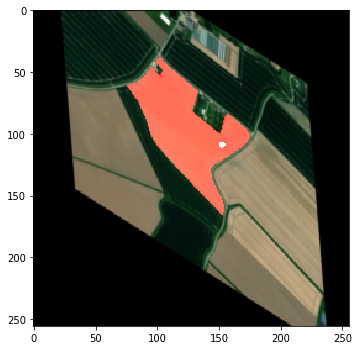

In [ ]:
gen = train_test_generator(json_filenames_test, 
                           batch_size=1, 
                           shear=True, 
                           flip=True, 
                           rot=True, 
                           zoom_pxs=220, 
                           shuffle=False, 
                           give_boundary_mask=False)

[batch_imgs, batch_mask_clickpoint], batch_mask_contour = next(gen)
batch_mask_clickpoint = img_as_float32(batch_mask_clickpoint)
batch_imgs[0][:,:,0][np.where(batch_mask_clickpoint[0][:,:,0]>0.5)]=1
batch_imgs[0][:,:,1][np.where(batch_mask_clickpoint[0][:,:,0]>0.5)]=1
batch_imgs[0][:,:,2][np.where(batch_mask_clickpoint[0][:,:,0]>0.5)]=1
batch_imgs[0][:,:,0][np.where(batch_mask_contour[0][:,:,0]>0.5)]=1
plt.figure(figsize=(5,5))
io.imshow(batch_imgs[0])

> ### UNET trainieren

In [ ]:
history = train_model(model, 
                      json_filenames_train, 
                      json_filenames_test, 
                      epochs=200, 
                      batch_size=32, 
                      log_dir="logs", 
                      savepath="best_weights.hdf5", 
                      savepath_hist="history.json", 
                      loadpath_hist=None, 
                      shear=True, 
                      flip=True, 
                      rot=True, 
                      zoom=True, 
                      zoom_pxs=220)